# Common

In [1]:
#!pip install tqdm

In [11]:
import json
import time
from subprocess import Popen, PIPE, STDOUT
import math
import numpy as np
import pandas as pd
import requests
import os, sys, subprocess
from tqdm.contrib.concurrent import process_map
from tqdm.notebook import tqdm
tqdm.pandas()
import multiprocessing as mp
import shutil
import urllib.parse
import glob
import os
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

In [12]:
current_path = os.getcwd()

In [13]:
def bracket_row(row):    
    s = row['data']
    index = min(s.find('.'), s.find('('))
    data = row['data']
    row['data'] = data[0:index]
    row['bracket'] = data[index:]
    return row

In [14]:
def adjust(text,n=7):
    text = str(text)    
    return " " * (n - len(text)) + text

In [15]:
def bracket_to_ct(tag, data, bracket, deltaG, negative_deltaG=True):    
    deltaG = deltaG.replace('(','').replace(')','')
    deltaG = float(deltaG)
    if(deltaG > 0 and negative_deltaG ): # negetive?!
        deltaG = -1 * deltaG
    stack = []
    index = np.zeros((len(bracket)), dtype = int)
    values = np.zeros((len(bracket)), dtype = int)
    for i in range(len(bracket)):
        index[i] = i + 1
        if(bracket[i] == '.'):
            values[i] = 0
        elif(bracket[i] == '('):
            stack.append(i)
        elif(bracket[i] == ')'):
            if(len(stack) == 0 ):
                print('structure error!')
            values[stack[-1]] = i + 1
            values[i]  = stack[-1] + 1
            stack.pop()
        else:
            print('structure error!')
    if(len(stack) != 0 ):
        print('structure error!')
    # body    
    ct = f"{adjust(len(data),6)} dG ={adjust(deltaG,10)} {tag}\n"   
    for i in range(len(bracket)):
        ct += f"{adjust(index[i],6)} {data[i]} {adjust(i,6)} {adjust((i+2)%(len(data)+1),6)} {adjust(values[i],6)} {adjust(index[i],7)}\n"
    return ct

In [16]:
def fasta_to_df(path):
    with open(path, 'r') as file:
        text = file.read()
    lines = [line for line in text.split('\n') if len(line) > 0]
    s = ''
    tags = []
    data = []
    for l in lines:
        if(l[0]=='>'):
            tags.append(l)        
            data.append(s)
            s = ''
        else:
            s += l    
    data.append(s)
    df = pd.DataFrame(
            {
                'tag': tags,
                'data': data[1:]
            })
    df['tag'] = df['tag'].apply(lambda x: x[1:])    
    return df

In [17]:
def df_to_fasta(df, path):
    lines = []
    df.apply(lambda row: lines.append(f">{row['tag']}\n{row['data']}\n"),axis=1)
    with open(path,'w') as file:
        file.write(''.join(lines))

In [18]:
def reformat(path):
    return path.replace('(','_').replace(')','_').replace('.','').replace(':','_')

In [19]:
def reformatCT(path):
    with open(path, 'r') as file:
        text = file.read()
    text = [l for l in text.split('\n') if len(l) > 0 ] # remove blank lines
    text = '\n'.join(text)
    text = text.replace("\t"," ")
    while("  " in text):
        text = text.replace("  ", " ")
    lines = [l for l in text.split('\n')]
    for i in range(len(lines)):
        if(lines[i][0] == " "):
            lines[i] = lines[i][1:]
        if(lines[i][-1] == " "):
            lines[i] = lines[i][:-1]
    text = '\n'.join(lines)
    return text

In [20]:
def get_ct_data(ct):
    ct = "\n".join(ct.split('\n')[1:])
    df = pd.read_csv(StringIO(ct), sep=" ", header=None)               
    nucleotide = df.iloc[:,1]
    index = df.iloc[:,5]
    values = df.iloc[:,4]
    return [nucleotide, index, values]

In [21]:
def ct2dot_bracket(path):
    [nucleotide, index, values] = get_ct_data(reformatCT(path))
    text = ''.join(nucleotide) + "\n"
    watch = []
    for i, v in zip(index,values):
        if(v == 0):
            text += '.'
        else:
            if( v not in watch):
                text += '('
                watch.append(i)
            if( v in watch):
                text += ')'
    return text

In [22]:
def is_nested(index, values):
    max_value = max(index) + 10 # inf
    for i, v in zip(index, values):
        if(v < max_value and v != 0):
            max_value  = v
        if(i >= max_value):
            max_value = max(index) + 10 # inf
        if(v > max_value):
            return False               
    return True

# CTAnalizer

In [23]:
sys.path.append("./src/")
from ct_analizer import get_row

In [24]:
def run(tag, path, extra):        
    return get_row(tag, path, extra)
    try:
        return get_row(tag, path,extra)
    except Exception as e:
        print(str(e), tag)        
        return pd.Series()        

# Apply on current data

In [25]:
base = "./CT_high_viridi"
cts = glob.glob(f'{base}/*.ct')

In [26]:
def get_df_by_path(path , extra=0):           
    tag = path[(len("./CT_high_viridi/")):-3]    
    return run(tag, path, extra)

In [27]:
max_workers = mp.cpu_count() - 4

dfs = []
for row in process_map(get_df_by_path , cts, tqdm_class=tqdm, max_workers=max_workers, chunksize=5):
    dfs.append(row)
result = pd.DataFrame(dfs)
result = result.replace(np.nan, '-').replace('', '-')            

  0%|          | 0/275 [00:00<?, ?it/s]

In [28]:
def get_max_in_region(row, type_str, size_str, region):
    out = 0
    mismatch_type = row[type_str]    
    for i in range(len(mismatch_type)):
        if mismatch_type[i] == region:
            if row[size_str][i] > out:
                out = row[size_str][i]
    return out

def get_number_in_region(row, type_str, size_str, region):
    counter = 0
    mismatch_type = row[type_str]    
    for i in range(len(mismatch_type)):
        if mismatch_type[i] == region:
            counter += 1            
    return counter

def get_sum_in_region(row, type_str, size_str, region):
    out = 0
    mismatch_type = row[type_str]    
    for i in range(len(mismatch_type)):
        if mismatch_type[i] == region:
            out += row[size_str][i]            
    return out

for region in ["loop distal", "hit region", "distal border line", "loop proximal", "proximal border line"]:
    result[f'max mismatch in {region}'] = result.apply(lambda row: get_max_in_region(row, "mismatch type", "mismatch size", region), axis=1)
    result[f'number mismatch in {region}'] = result.apply(lambda row: get_number_in_region(row, "mismatch type", "mismatch size", region), axis=1)
    result[f'sum mismatch in {region}'] = result.apply(lambda row: get_sum_in_region(row, "mismatch type", "mismatch size", region), axis=1)    
    result[f'max bulge in {region}'] = result.apply(lambda row: get_max_in_region(row, "bulge type", "bulge size", region), axis=1)
    result[f'number bulge in {region}'] = result.apply(lambda row: get_number_in_region(row, "bulge type", "bulge size", region), axis=1)
    result[f'sum bulge in {region}'] = result.apply(lambda row: get_sum_in_region(row, "bulge type", "bulge size", region), axis=1)
    result[f'max loop in {region}']= result.apply(lambda row: get_max_in_region(row, "internal type", "internal loop total size", region), axis=1)
    result[f'number loop in {region}']= result.apply(lambda row: get_number_in_region(row, "internal type", "internal loop total size", region), axis=1)
    result[f'sum loop in {region}']= result.apply(lambda row: get_sum_in_region(row, "internal type", "internal loop total size", region), axis=1)

In [29]:
def sum_of_size_in_hit(row, type_str, size_str):
    _sum = 0
    mismatch_type = row[type_str]
    for i in range(len(mismatch_type)):
        if mismatch_type[i] == "hit region":
            _sum += row[size_str][i]
    return _sum


def number_of_residue(row):
    hit_end = row['hit end']    
    hit_start = row['hit start']
    psep = row['psep']
    if(psep == '-'):
        return 0
    mir_type = row['mir type']
    if mir_type == '5p':
        if psep < hit_end:
            return hit_end - psep
    if mir_type == '3p':
        if psep > hit_start:
            return psep - hit_start
    return 0


def sum_of_size_in_border_line(row, border_type, type_str, size_str, start, end):
    _sum = 0
    _size = row[size_str]    
    _start = row[start]    
    _end = row[end]
    mir_type = row['mir type']     
    mismatch_type = row[type_str]    
    for i in range(len(mismatch_type)):
        if mismatch_type[i] == border_type:
            if border_type == "distal border line":
                if mir_type  == '5p':
                    _sum += _size[i] - _start[i]
                if mir_type == '3p':
                    _sum += _size[i] - _end[i]
            if border_type == "proximal border line":
                if mir_type == '5p':
                    _sum += _size[i] - _end[i]
                if mir_type == '3p':
                    _sum += _size[i] - _start[i]
    return _sum


def check_involvement(row):
    if(row['number of terminal structures'] == "-"):
        return None
    if(row['number of terminal structures'] > 1):
        return True
    start = row['branch#1 apical loop start']
    end = row['branch#1 apical loop end']
    for col in ['hit start', 'hit end', 'star start', 'star end']:
        if(start < row[col] < end ):
            return False                    
    return True

sum_missmatch = result.apply(lambda row: sum_of_size_in_hit(row, 'mismatch type', 'mismatch size'), axis=1)
sum_bulge = result.apply(lambda row: sum_of_size_in_hit(row, 'bulge type', 'bulge size'), axis=1)
sum_internal = result.apply(lambda row: sum_of_size_in_hit(row, 'internal type', 'internal loop total size'), axis=1)
sum_missmatch_border_proximal = result.apply(lambda row: sum_of_size_in_border_line(row, 'proximal border line', 'mismatch type', 'mismatch size', 'mismatch start', 'mismatch end'), axis=1)
sum_missmatch_border_distal = result.apply(lambda row: sum_of_size_in_border_line(row, 'distal border line', 'mismatch type', 'mismatch size', 'mismatch start', 'mismatch end'), axis=1)
sum_bulge_border_proximal = result.apply(lambda row: sum_of_size_in_border_line(row, 'proximal border line', 'bulge type', 'bulge size', 'bulge start', 'bulge end'), axis=1)
sum_bulge_border_distal = result.apply(lambda row: sum_of_size_in_border_line(row, 'distal border line', 'bulge type', 'bulge size', 'bulge start', 'bulge end'), axis=1)
sum_internal_border_proximal = result.apply(lambda row: sum_of_size_in_border_line(row, 'proximal border line', 'internal type', 'internal loop HSBL', 'internal start', 'internal end'), axis=1)
sum_internal_border_distal = result.apply(lambda row: sum_of_size_in_border_line(row, 'distal border line', 'internal type', 'internal loop HSBL', 'internal start', 'internal end'), axis=1)
sum_of_residue = result.apply(lambda row: number_of_residue(row), axis=1)


result['sum of residue in terminal loop'] = sum_of_residue


_sum = sum_bulge + sum_internal + sum_bulge_border_proximal + sum_bulge_border_distal + sum_internal_border_proximal + sum_internal_border_distal + sum_of_residue
result["ACCEPTABLE_NUM_FOR_HIT_LOCATIONS_IN_BULGES_OR_LOOPS"] = _sum

result["ACCEPTABLE_NUM_FOR_UNMATCHED_LOCATIONS_IN_HIT_REGION * 2"] = (_sum + (sum_missmatch + sum_missmatch_border_proximal + sum_missmatch_border_distal) * 2)
result["ACCEPTABLE_NUM_FOR_UNMATCHED_LOCATIONS_IN_HIT_REGION"] = (_sum + (sum_missmatch + sum_missmatch_border_proximal + sum_missmatch_border_distal))

result["TOTAL_NUM_OF_MISMACHED_POSITIONS"] = sum_missmatch

result["TOTAL_NUM_OF_NONMATCHING_POSITIONS"] = (sum_missmatch + sum_bulge + sum_internal)

result["TOTAL_NUM_OF_POSITIONS_IN_BULGES_AND_LOOPS"] = (sum_bulge + sum_internal)

result["MATURE_DUPLEX_INVOLVEMENT_IN_APICAL_LOOP"] = result.apply(lambda row: check_involvement(row), axis=1)

In [30]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'ACCEPTABLE_NUM_FOR_UNMATCHED_LOCATIONS_IN_HIT_REGION')

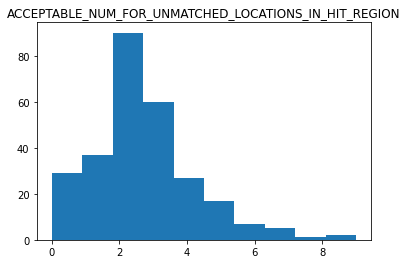

In [31]:
v = result['ACCEPTABLE_NUM_FOR_UNMATCHED_LOCATIONS_IN_HIT_REGION']
plt.hist(v)
plt.title("ACCEPTABLE_NUM_FOR_UNMATCHED_LOCATIONS_IN_HIT_REGION")

In [32]:
result.to_csv("./Result/confident_viridi_ct_analizer.csv", index=False)    